# Stock Market Analyzation

## Goal

What we desire to know is to learn the skills to analyze the Stock Market. Using a list of 5 curated questions, we will try to analyze and make assumptions based off stock market data

## Questions

1) What are the most relevant factors in producing a high quarterly return?

2) What common patterns do we see in the market resulting in an increase of decrease in price?

3) How close is a stock’s price related to the other stocks in its subclass / sector?

4) How have tech giants been affected by the introduction of AI?

5) Do people who affect our laws have stock options that correlate with price changes?


## How will we answer these questions

Using Data Science & Mahcince Learning tehcinques we will closely analyze these stocks and their features.

The main stock example we'll examine when looking at individual stocks is Microsoft, however Nvidia is also a great option.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ta
import requests
import kagglehub
import lightgbm as lgb


from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

### Importing the Needed Libraries & tools

### Importing the Needed Datsets

Kaggle
 - sp500_stocks.csv
 - sp500_companies.csv

Senate Stock Watcher
 - all_transactions.csv

In [2]:
# Downloading latest version of stock market price data
pathes = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

pathes = os.path.normpath(pathes)

sp500_stocks = pd.read_csv( os.path.join(pathes, "sp500_stocks.csv") ).dropna()
sp500_stocks


# Downloading latest version of stock market company data
pathes = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

pathes = os.path.normpath(pathes)

sp500_companies = pd.read_csv( os.path.join(pathes, "sp500_companies.csv") ).dropna()
sp500_companies


# Downloading latest version of all transactions file
url = "https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json"

response = requests.get(url)
data = response.json()

all_transactions = pd.DataFrame(data)
all_transactions = all_transactions[all_transactions['asset_type'] == 'Stock'].drop(['comment', 'industry', 'state', 'sector','ptr_link', 'asset_description', 'amount', 'party', 'disclosure_date'], axis=1).dropna()
all_transactions

,transaction_date,owner,ticker,asset_type,type,senator
0,04/18/2023,Spouse,ESS,Stock,Sale (Full),Sheldon Whitehouse
1,04/18/2023,Self,ESS,Stock,Sale (Full),Sheldon Whitehouse
3,04/04/2023,Spouse,UPS,Stock,Sale (Full),Shelley Moore Capito
4,04/04/2023,Spouse,MCD,Stock,Sale (Partial),Shelley Moore Capito
5,04/04/2023,Spouse,DUK,Stock,Sale (Full),Shelley Moore Capito
...,...,...,...,...,...,...
7637,12/11/2014,Spouse,DVFAX,Stock,Purchase,Susan M. Collins
7640,12/12/2014,Spouse,XOM,Stock,Sale (Full),Pat Roberts
7641,12/19/2014,Spouse,BA,Stock,Purchase,Pat Roberts
7642,12/12/2014,Spouse,BAC,Stock,Sale (Full),Pat Roberts


## Question 1

### What are the most relevant factors in producing a high return?

Here we foucs on what is import in producing a high stock value for returns.

Using available predictors we have from our datasets, we will figure out what is most important in achieving a high value returns.

The most relevant factors are found using a Light Gradient Boosting Machine.


Datasets used are:
 - sp500_stocks.csv
 - sp500_companies.csv

#### What the model will use

What is being predictd

 - Quartly Market High

What are the predictors
 - Sector
 - Industry
 - Currentprice
 - Marketcap
 - Ebitda
 - Revenuegrowth
 - City
 - State
 - Country
 - Fulltimeemployees
 - Weight
 - Volume

In [3]:
stocks_updated = sp500_stocks.drop(['Adj Close', 'Close', 'Low', 'Open'], axis=1)

companies_updated = sp500_companies.drop(['Exchange', 'Shortname', 'Longname', 'Longbusinesssummary'], axis=1)

In [4]:
merged_stock = stocks_updated.merge(companies_updated, on='Symbol')
merged_stock = merged_stock.dropna()

Gathering the important features

In [5]:
categorical_features = ['Sector', 'Industry', 'City', 'State', 'Country']  

for col in categorical_features:
    le = LabelEncoder()
    merged_stock[col] = le.fit_transform(merged_stock[col])

for col in categorical_features:
    merged_stock[col] = merged_stock[col].astype('category')

In [6]:
y = merged_stock['High']

x = merged_stock.drop(['Date','High','Symbol'], axis=1)

erged_stock = merged_stock.sort_values('Date').reset_index(drop=True)

train_size = int(0.8 * len(merged_stock))

X_train = x.iloc[:train_size]
X_test = x.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

### evaluating the features using Light Gradient Boosting Machine.

In [7]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical_features)

In [8]:
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting': 'gbdt',  # Gradient Boosting Decision Tree
    'learning_rate': 0.05,
    'num_leaves': 31,  
    'max_depth': -1, 
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,  # Performs bagging every k iterations
    'verbose': -1
}

In [9]:
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval]
)

### Using the Light Gradient Boosting Machine

Once a prediction is made it is tested, using RMSE & MSE

In [10]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [11]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 111.82956667143071
MAE: 67.23682035477863


In [12]:
importance = gbm.feature_importance()
feature_names = gbm.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

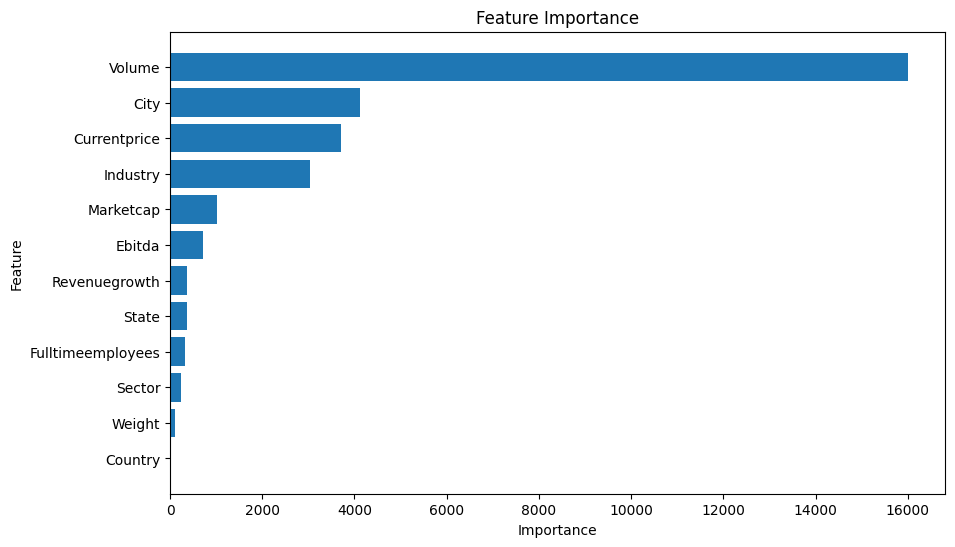

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

### Analyzing the data

Using the data of most important features above, we can see the most important features respectively are Volume, City, & Current Price. While volume & current price make sense, it is interesting that City makes a different in determining the price.

## Question 2

### What common patterns do we see in the market resulting in an increase of decrease in price?

Here we foucs on how to recognize patterns in the stock market so we can try to predict future increase or decreases of price

Datasets used are:
 - sp500_stocks.csv

In [14]:
stocks = sp500_stocks.drop('Adj Close', axis=1)

### Choosing the stock we want to look at

enter the Symbol of the stock you want to examine

In [15]:
desired_stock = 'MSFT'

### Cleaning the data & creating an important function

In [16]:
stocks['Daily Returns'] = stocks['Open']-stocks['Close'] / stocks['Close']
stocks['Price_Range'] = stocks['High'] - stocks['Low']
stocks['Price_Change'] = stocks['Close'] - stocks['Open']
stocks['Volatility'] = (stocks['High'] - stocks['Low']) / stocks['Close']
stock_of_interest = stocks[stocks['Symbol'] == desired_stock ]

This functions is used to update and add usful features in determining how correlated stock prices are.

In [ ]:
def get_features( df ):
    # Moving Averages
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    # RSI (using ta library)
    
    df['RSI'] = ta.momentum.RSIIndicator(stocks['Close'], window=14).rsi()

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA_10'] + 2 * df['Close'].rolling(window=10).std()
    df['Bollinger_Lower'] = df['MA_10'] - 2 * df['Close'].rolling(window=10).std()

    # Lagged Returns
    df['Lag_1'] = df['Daily Returns'].shift(1)
    df['Lag_2'] = df['Daily Returns'].shift(2)

    df['Label'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    

In [18]:
get_features(stock_of_interest)
stock_of_interest = stock_of_interest.dropna()

C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\3278626729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_10'] = df['Close'].rolling(window=10).mean()
C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\3278626729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_50'] = df['Close'].rolling(window=50).mean()
C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\3278626729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

### What our stock data looks like

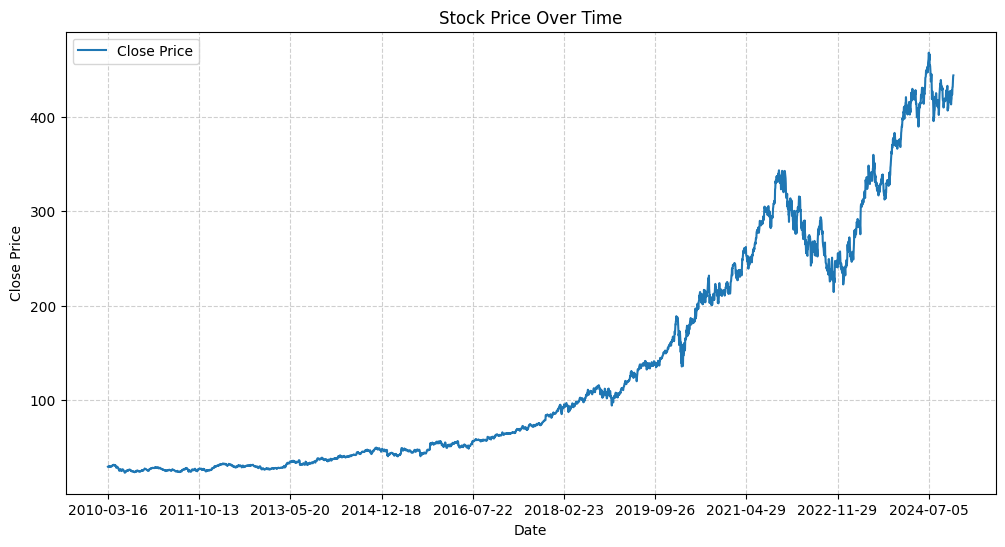

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(stock_of_interest['Date'], stock_of_interest['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(stock_of_interest['Date'][::400]) 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

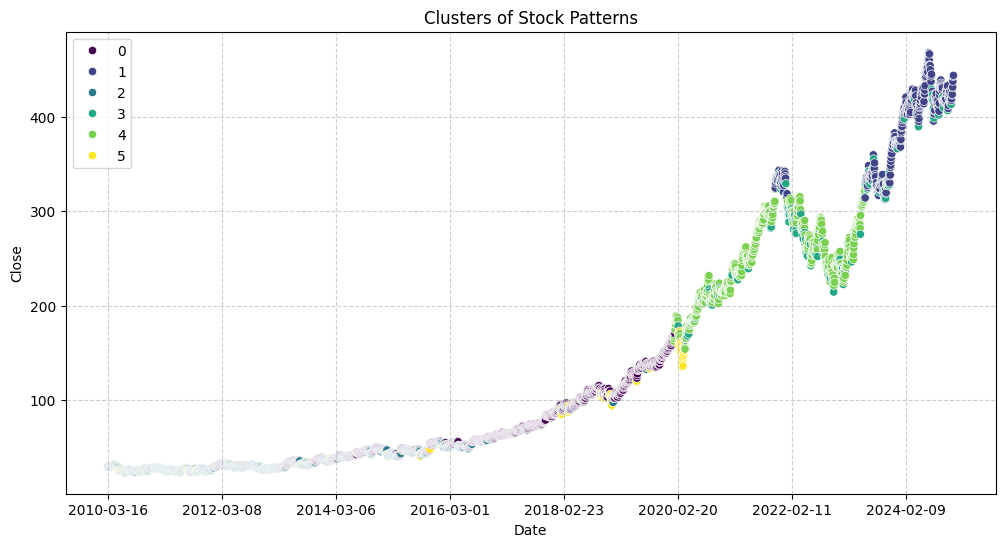

In [20]:
# Features for clustering
features = ['Daily Returns','Close','High','Volume','Price_Range','Price_Change','Volatility','MA_10','MA_50','RSI','Bollinger_Upper','Bollinger_Lower','Lag_1','Lag_2']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stock_of_interest[features])

# Apply K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
stock_of_interest['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=stock_of_interest, x='Date', y='Close', hue='Cluster', palette='viridis')
plt.title('Clusters of Stock Patterns')
plt.xticks(stock_of_interest['Date'][::500]) 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

### Analyzing the data

As we can observe from this stock data, the relative cluster relates to how fast the price will increase in the near future. For instance, the yellow leads to the purple increase, and this purple increase leads to the teal price.

While this seems to show the patterns for the increase / high of prices, it would be interesting to find a feature that relates to the decrease in stock price.

### Ranking the Important Features

here we will find a rank the most important features involving in finding increases and decreases of prices

In [21]:
features = [
    'Daily Returns', 'Close', 'High', 'Volume', 'Price_Range', 
    'Price_Change', 'Volatility', 'MA_10', 'MA_50', 'RSI', 
    'Bollinger_Upper', 'Bollinger_Lower', 'Lag_1', 'Lag_2'
]

X = stock_of_interest[features].dropna()

stock_of_interest['Label'] = (stock_of_interest['Close'].shift(-1) > stock_of_interest['Close']).astype(int)

y = stock_of_interest.loc[X.index, 'Label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.48      0.49       530
           1       0.53      0.54      0.54       583

    accuracy                           0.51      1113
   macro avg       0.51      0.51      0.51      1113
weighted avg       0.51      0.51      0.51      1113



In [22]:
importances = model.feature_importances_
ranked_features = {}
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

Daily Returns: 0.0611
Close: 0.0602
High: 0.0623
Volume: 0.0883
Price_Range: 0.0724
Price_Change: 0.0889
Volatility: 0.0824
MA_10: 0.0636
MA_50: 0.0695
RSI: 0.0869
Bollinger_Upper: 0.0663
Bollinger_Lower: 0.0675
Lag_1: 0.0659
Lag_2: 0.0648


### Analyzing the data

For Microsoft, the most important features in our stock is Volume, followed by RSI, then Price Change. These are what allow us to best guess what factors are important when finding common patterns in the market.

## Question 3

### How close is a stock’s price related to the other stocks in its subclass / sector?

The goal is to see how close a stocks price is related to other stocks in its subclass / sector.

This is done by looking at given & created features of a stock, to see if their growth is related to other stocks.

Datasets used are:
 - sp500_companies.csv
 - sp500_stocks.csv


Sectors that will be reviewed:
 - Technology
 - Communication Services
 - Consumer Cyclical
 - Financial Services
 - Healthcare
 - Consumer Defensive
 - Energy
 - Basic Materials
 - Industrials
 - Utilities
 - Real Estate

#### Cleaning the data

The data of the stocks is combined with the data of the stock's price. This new data is then further modified to provided other data points for us to help guess how related the stocks are to each other.

In [23]:
stocks_updated = sp500_stocks.drop('Volume', axis=1)
companies_updated = sp500_companies.drop(['Exchange', 'Shortname', 'Longname', 'Industry', 'Currentprice', 'Marketcap','Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary','Weight'], axis=1)

input_stocks = stocks_updated.merge(companies_updated, on='Symbol')

daily_return = pd.DataFrame( {'Daily Return':input_stocks['Open']-input_stocks['Close'] / input_stocks['Close']})

input_stocks['Daily Return'] = daily_return
input_stocks = input_stocks.drop(['Adj Close', 'Close', 'High', 'Low', 'Open'], axis=1)
input_stocks = input_stocks.set_index('Date')

Here the data is update so the each stock is a column, with the rows being the the prices of on the index's date.

In [24]:
input_technology = input_stocks[input_stocks['Sector'] == 'Technology'].pivot(columns='Symbol', values='Daily Return')
input_communication = input_stocks[input_stocks['Sector'] == 'Communication Services'].pivot(columns='Symbol', values='Daily Return')
input_cyclical = input_stocks[input_stocks['Sector'] == 'Consumer Cyclical'].pivot(columns='Symbol', values='Daily Return')
input_financial = input_stocks[input_stocks['Sector'] == 'Financial Services'].pivot(columns='Symbol', values='Daily Return')
input_healthcare = input_stocks[input_stocks['Sector'] == 'Healthcare'].pivot(columns='Symbol', values='Daily Return')
input_defensive = input_stocks[input_stocks['Sector'] == 'Consumer Defensive'].pivot(columns='Symbol', values='Daily Return')
input_energy = input_stocks[input_stocks['Sector'] == 'Energy'].pivot(columns='Symbol', values='Daily Return')
input_basic = input_stocks[input_stocks['Sector'] == 'Basic Materials'].pivot(columns='Symbol', values='Daily Return')
input_industrials = input_stocks[input_stocks['Sector'] == 'Industrials'].pivot(columns='Symbol', values='Daily Return')
input_utilities = input_stocks[input_stocks['Sector'] == 'Utilities'].pivot(columns='Symbol', values='Daily Return')
input_estate = input_stocks[input_stocks['Sector'] == 'Real Estate'].pivot(columns='Symbol', values='Daily Return')


A Correlation matirx of these stocks is then made, this is what will be made into a distance matrix from each other stocks correlation. This distance matrix is then used to estimate how closely related stocks are to one another.

In [25]:

corr_technology = input_technology.corr()
corr_communication = input_communication.corr()
corr_cyclical = input_cyclical.corr()
corr_financial = input_financial.corr()
corr_healthcare = input_healthcare.corr()
corr_defensive = input_defensive.corr()
corr_energy = input_energy.corr()
corr_basic = input_basic.corr()
corr_industrials = input_industrials.corr()
corr_utilities = input_utilities.corr()
corr_estate = input_estate.corr()

technology_distance_matrix = np.sqrt(2 * (1 - corr_technology))
communication_distance_matrix = np.sqrt(2 * (1 - corr_communication))
cyclical_distance_matrix = np.sqrt(2 * (1 - corr_cyclical))
financial_distance_matrix = np.sqrt(2 * (1 - corr_financial))
healthcare_distance_matrix = np.sqrt(2 * (1 - corr_healthcare))
defensive_distance_matrix = np.sqrt(2 * (1 - corr_defensive))
energy_distance_matrix = np.sqrt(2 * (1 - corr_energy))
basic_distance_matrix = np.sqrt(2 * (1 - corr_basic))
industrials_distance_matrix = np.sqrt(2 * (1 - corr_industrials))
utilities_distance_matrix = np.sqrt(2 * (1 - corr_utilities))
estate_distance_matrix = np.sqrt(2 * (1 - corr_estate))

The Agglomerative Clusting is used to calculate the appropriate clusters using the given distance matrix. Then a prediction is made for each sector.

In [26]:
clustering = AgglomerativeClustering(
    n_clusters=7,          
    metric='precomputed',
    linkage='average'      
)

In [27]:

technology_prediction = clustering.fit_predict(technology_distance_matrix)
communication_prediction = clustering.fit_predict(communication_distance_matrix)
cyclical_prediction = clustering.fit_predict(cyclical_distance_matrix)
financial_prediction = clustering.fit_predict(financial_distance_matrix)
healthcase_prediction = clustering.fit_predict(healthcare_distance_matrix)
defensive_prediction = clustering.fit_predict(defensive_distance_matrix)
energy_prediction = clustering.fit_predict(energy_distance_matrix)
basic_prediction = clustering.fit_predict(basic_distance_matrix)
industrials_prediction = clustering.fit_predict(industrials_distance_matrix)
utilities_prediction = clustering.fit_predict(utilities_distance_matrix)
estate_prediction = clustering.fit_predict(estate_distance_matrix)


### Displaying the Clusters of stocks

each point represnets a stock and its color the cluster of stock it is in. Each stock in a cluster is one the is related to the others in the cluster around it. This is visualized by using Multidimensional Scaling.

For this example we will look at the industrial sector.

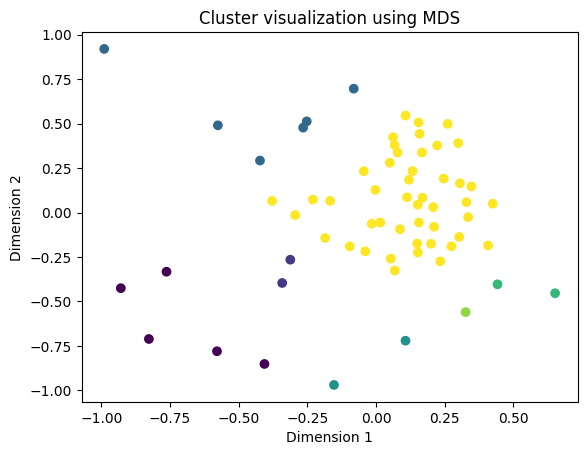

In [28]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_mds = mds.fit_transform(industrials_distance_matrix)

plt.scatter(X_mds[:, 0], X_mds[:, 1], c=industrials_prediction)
plt.title("Cluster visualization using MDS")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Analyzing the data

As seen using the industrial sector there is a correlation between the price of a stock and it's sector. there is a large cluster to which most stocks correlate to. However for all but a small handfull, most stocks correlate to the price & factors of the other stock around it.

## **Question 4**

### How have tech giants been affected by the introduction of AI?

Here we foucs on how to AI may have affect stock market prices for some larger companies that use AI today.

For this we will compare some events of intrest that relate to AI. 
Using these dates, we can guess if anything important had happened regarding the stock's price becuase of how close these events where to increases or decreases in price.

#### Some Events

1. **2013-10**
 - *Watson Devloper Cloud is released for access, allowing users to use IBMs cloud computing*

2. **2016-03-15**
 - *DeepMind Challenge Match was a five-game Go match between Lee Sedol, a top Go player, and AlphaGo, a computer program developed by DeepMind*

3. **2017-06**
 - *'Attention is All You Need' releases*

4. **2018-06**
 - *Chat GBT 1.0 is released*

5. **2023-01**
 - Microsoft invests 10 Billion into Open AI*

6. **2023-03-14**
 - *Anthropic launched Claude, its ChatGPT alternative.*

7. **2023-11-30**
 - *ChatGBT 3.5 is shown to public*


### Choosing the stock we want to look at

enter the Symbol of the stock you want to examine

In [29]:
desired_stock = 'MSFT'

### Cleaning the data

Once you have chosen your desired stock, more features are used to help make predictions and assumptions. The dates of interest are then used to get the price of the stock during the events. 

This is then plotted.

C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\296532094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_stock['Price Change'] = updated_stock['Close'].diff()  # Absolute change
C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\296532094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_stock['% Change'] = updated_stock['Close'].pct_change() * 100
C:\Users\idmac\AppData\Local\Temp\ipykernel_31272\296532094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli




Results from data:
               Date  Price Change  % Change       MA_10       MA_50
1195996  2013-10-15      0.040001  0.116113   33.787000   32.826600
1196603  2016-03-15      0.420002  0.789923   52.473000   52.011800
1196919  2017-06-15     -0.369995 -0.526534   71.181999   68.481600
1197171  2018-06-15     -1.290001 -1.271939  101.361999   96.851400
1198364  2023-03-14      6.870010  2.705581  253.300999  249.054001
1198545  2023-11-30      0.059998  0.015837  377.088004  343.608804


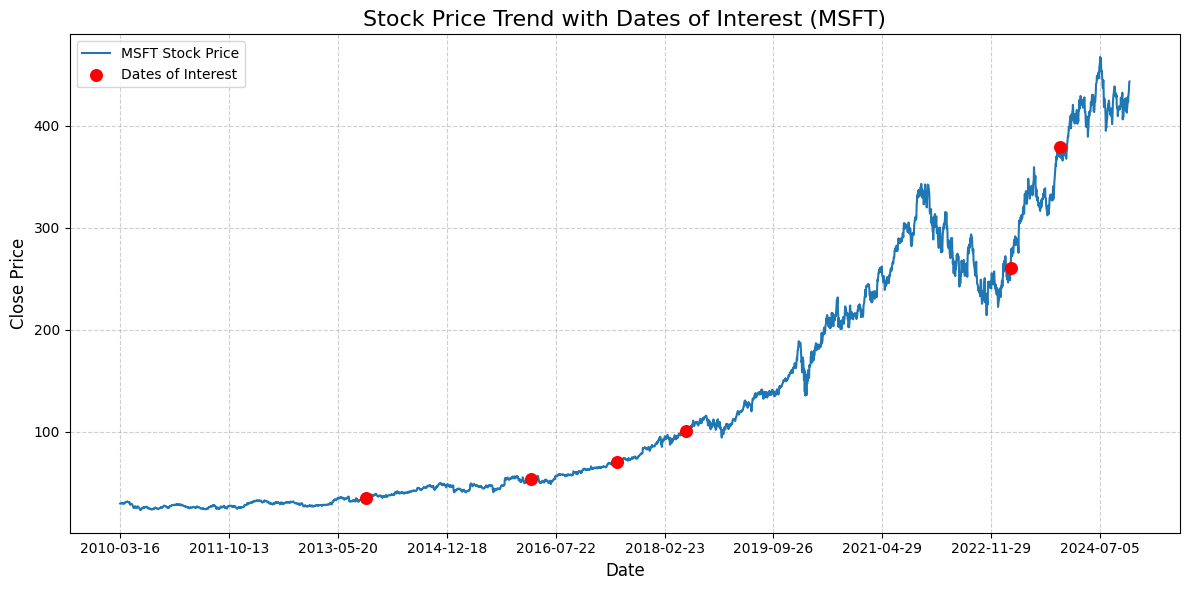

In [30]:
dates_of_interest = ['2013-10-15', '2016-03-15', '2017-06-15','2018-06-15', '2023-01-15', '2023-03-14', '2023-11-30']

stocks = sp500_stocks
updated_stock = stocks[stocks['Symbol'] == desired_stock]
updated_stock['Price Change'] = updated_stock['Close'].diff()  # Absolute change
updated_stock['% Change'] = updated_stock['Close'].pct_change() * 100 
updated_stock['MA_10'] = updated_stock['Close'].rolling(window=10).mean()
updated_stock['MA_50'] = updated_stock['Close'].rolling(window=50).mean()
updated_stock = updated_stock.dropna()

# Collecting the data that is relevant to the dates of interest
filtered_data = updated_stock[updated_stock['Date'].isin(dates_of_interest)] 

# Keeping whats only important to disply
results = filtered_data.drop(['Symbol', 'Adj Close', 'Open', "Close", 'High', 'Low', 'Volume'], axis=1)

print("\n\n\nResults from data:")
print(results)



plt.figure(figsize=(12, 6))
plt.plot(updated_stock['Date'], updated_stock['Close'], label=f'{desired_stock} Stock Price', linewidth=1.5)

plt.scatter(
    filtered_data['Date'], 
    filtered_data['Close'], 
    color='red', 
    s=70, 
    label='Dates of Interest', 
    zorder=5
)

plt.title(f'Stock Price Trend with Dates of Interest ({desired_stock})', fontsize=16)
plt.xlabel('Date', fontsize=12) 
plt.xticks(updated_stock['Date'][::400]) 
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

### Analyzing the data

As potrayed about some of the events correlate with an increase of the price. This is not entiarly surprising as the stock we use for our example, is directly related to some of the major events that have occured.

## **Question 5**

### Do people who affect our laws have stock options that correlate with price changes?

Here we foucs on if US Senator's stock purchase & sale relate to a stock's increase or decrease in price.

We will take the stock price & the transactions of US Senate members regarding that stock. We will then compare the time this transaction took place and what type it was.


Datasets used are:
 - sp500_stocks.csv
 - all_senator_transactions.csv

### Choosing the stock we want to look at

enter the Symbol of the stock you want to examine

Some symbols that have a decent amount of data are
 - AAPL: 182
 - MSFT: 102
 - T: 70
 - NVDA: 62
 - AMZN: 60

In [31]:
desired_stock = 'MSFT'

### Cleaning the data

Taking the sp500 stocks data and keeping only each stocks symbol, date, and close price. This stock data is then changed to the only the data of the desired stock.

Takes the transaction of each Senators stock data and kept the date, symbol, sentor, and if it was a purchase or sale. These transactoins are then set to the desired stock.

In [32]:
stocks = sp500_stocks.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1).dropna()

stock = stocks[stocks['Symbol'] == desired_stock]


transactions = all_transactions
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%m/%d/%Y')
transactions['transaction_date'] = transactions['transaction_date'].dt.strftime('%Y-%m-%d')

stock_transactions = transactions[transactions['ticker'] == desired_stock]
stock_transactions = stock_transactions.dropna()


full_sale_transactions = stock_transactions[stock_transactions['type'] == 'Sale (Full)']
partial_sale_transaction = stock_transactions[stock_transactions['type'] == 'Sale (Partial)']
purchase_transaction = stock_transactions[stock_transactions['type'] == 'Purchase']

full_sale_data = stock[stock['Date'].isin(full_sale_transactions['transaction_date'])] 
partial_sale_data = stock[stock['Date'].isin(partial_sale_transaction['transaction_date'])] 
purchase_data = stock[stock['Date'].isin(purchase_transaction['transaction_date'])] 

### Stock Price & Senator Purchases

Displays the stock close price date over time. This is in parter with a scatter plot of the full sale, patial sale, and purchase of the specified stock.

The Stock actions are displayed by:
 - Green - purchase
 - red - full sale
 - yellow - partial sale

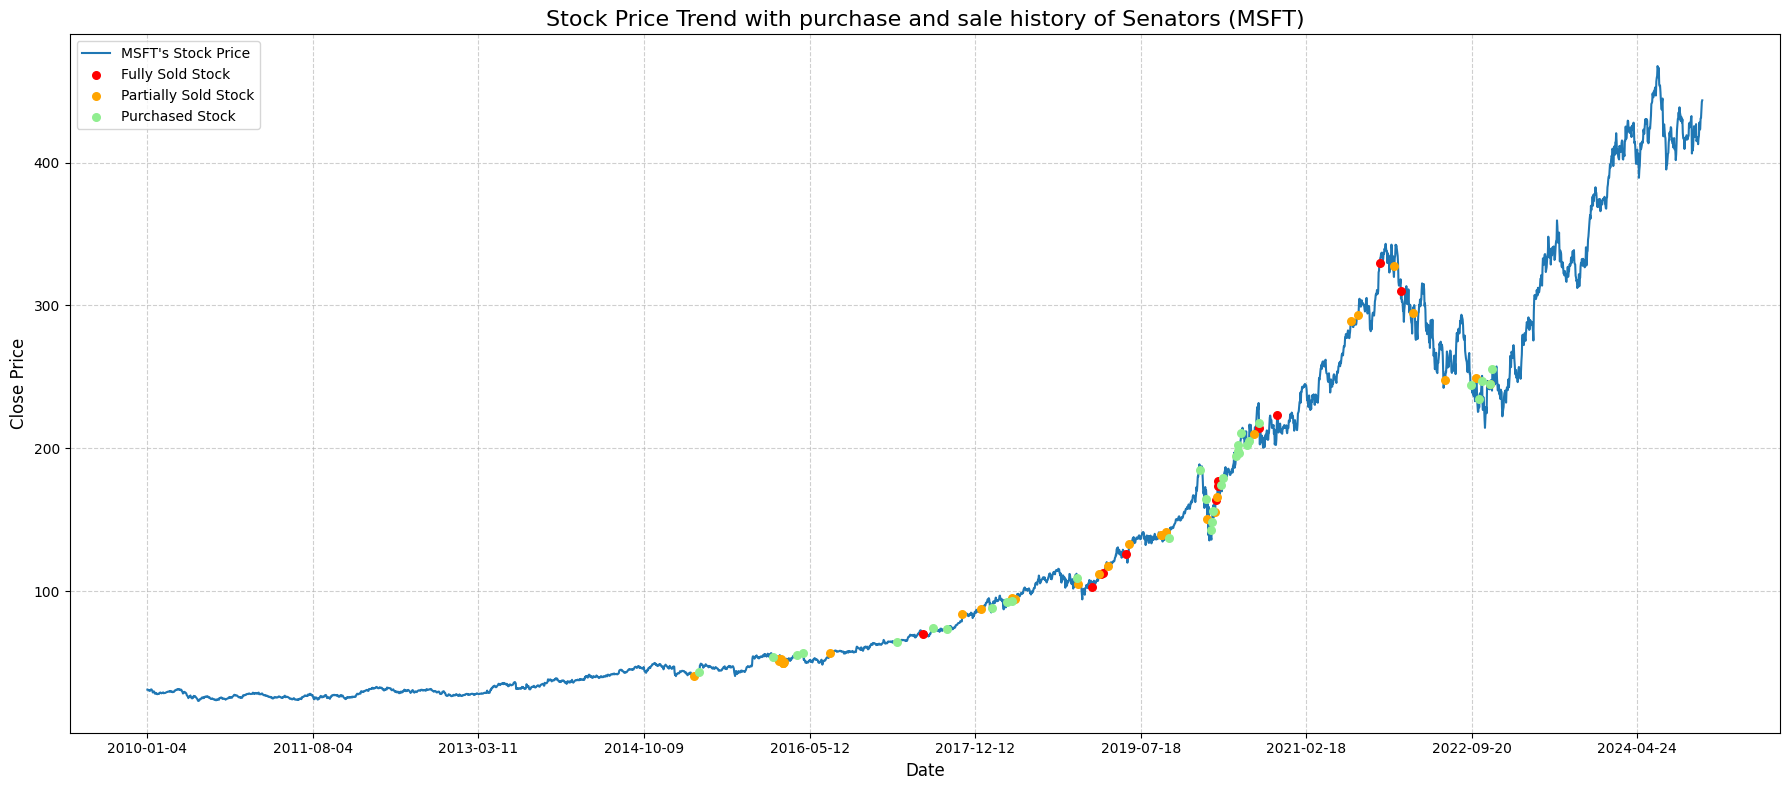

In [36]:
plt.figure(figsize=(18, 8))
plt.plot(stock['Date'], stock['Close'], label=f"{desired_stock}'s Stock Price", linewidth=1.5)

# Scatter plot for dates of interest
plt.scatter(
    full_sale_data['Date'], 
    full_sale_data['Close'], 
    color='red', 
    s=30, 
    label='Fully Sold Stock', 
    zorder=5
)

plt.scatter(
    partial_sale_data['Date'], 
    partial_sale_data['Close'], 
    color='orange', 
    s=30, 
    label='Partially Sold Stock', 
    zorder=5
)

plt.scatter(
    purchase_data['Date'], 
    purchase_data['Close'], 
    color='#90EE90', 
    s=30, 
    label='Purchased Stock', 
    zorder=5
)

plt.title(f'Stock Price Trend with purchase and sale history of Senators ({desired_stock})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.xticks(stock['Date'][::400]) 
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Analyzing the data

Using the set example Microsoft, we can see that, past 2019, the Senate had bought before 2 large spikes in price. However previous to this, there are not many indications of someone buying before a price increase.

However, this did not continue with selling. As after a member of the senate sold, there are nultiple instances of the price increasing.

Assuming we knew that they were commiting inside trading, with this data we would be able to confirm that any insider information they receive is more beneficial when buying stock than when selling stock.

## Future Work

In the future, I would love to have access to more diverse array of stock information along with more information on those stocks. It would also be interesting to have access to a database about AI events, that way a more official version of the dates of interests can be created. Also, it would be interesting to have access to the House of Representatives stock options to give a better look at what knowledge they might have regarding stock options.

